In [1]:
"""
Predict Lemons for the Kaggle Carvana competition

See

TODO:
    - (kevin.s): impute values
    - (kevin.s): 
    - (kevins.s): identify & exclude outliers
    - (kevin.s): build a quick model
"""

import os.path
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

/Users/kevinschenthal/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Load the data
dir_data = '/Users/kevinschenthal/Desktop/kaggle/auto'
train = pd.read_csv(os.path.join(dir_data, 'training.csv'))
test = pd.read_csv(os.path.join(dir_data, 'test.csv'))

In [4]:
# Identify target column
target = 'IsBadBuy'

Weight,Feature
-0.0005 ± 0.0004,IsOnlineSale
-0.0064 ± 0.0019,VNZIP1
-0.0070 ± 0.0016,VehOdo
-0.0071 ± 0.0017,WarrantyCost
-0.0081 ± 0.0022,BYRNO
-0.0107 ± 0.0016,VehicleAge
-0.0111 ± 0.0013,VehYear


In [11]:
# =============================================================================
# Analyze column types, filles, and values
# =============================================================================

cols = []
fill_rates = []
uniques = []
for col in train.columns:
    fill_rate = train[col].notnull().sum() / train.shape[0]
    col_uniq_rate = train[col].nunique() / train.shape[0]
    cols.append(col)
    fill_rates.append(fill_rate)
    uniques.append(col_uniq_rate)
    
diagnostic_df = pd.DataFrame({'column': cols,
                              'fill_rates': fill_rates,
                              'unique_rate': uniques})
describe_df = (train.describe()
                    .transpose()
                    .reset_index()
                    .rename(columns={'index': 'column'}))
diagnostic_df = diagnostic_df.merge(describe_df, on='column')

# We note that the fill rate is at worse 0.95 for WheeltypeID, so we impute
# columns with the median

# Add column type
col_type_df = (train.dtypes.to_frame()
                           .reset_index()
                           .rename(columns={'index': 'column',
                                            0: 'dtype'}))
diagnostic_df = diagnostic_df.merge(col_type_df, on='column')
    
# =============================================================================
# IMPUTE MISSING VALUES
# =============================================================================

cols_with_nans = list(diagnostic_df.loc[diagnostic_df.fill_rates < 1., 'column'])
for col in cols_with_nans:
    # Train
    col_median = train[col].median()
    train[col] = train[col].fillna(col_median)
    
    # Test
    col_median = test[col].median()
    test[col] = test[col].fillna(col_median)

In [16]:
print(diagnostic_df)

                               column  fill_rates  unique_rate    count  \
0                               RefId    1.000000     1.000000  72983.0   
1                            IsBadBuy    1.000000     0.000027  72983.0   
2                             VehYear    1.000000     0.000137  72983.0   
3                          VehicleAge    1.000000     0.000137  72983.0   
4                         WheelTypeID    0.956579     0.000055  69814.0   
5                              VehOdo    1.000000     0.547347  72983.0   
6   MMRAcquisitionAuctionAveragePrice    0.999753     0.141704  72965.0   
7     MMRAcquisitionAuctionCleanPrice    0.999753     0.155913  72965.0   
8    MMRAcquisitionRetailAveragePrice    0.999753     0.174356  72965.0   
9       MMRAcquisitonRetailCleanPrice    0.999753     0.184372  72965.0   
10      MMRCurrentAuctionAveragePrice    0.995684     0.141334  72668.0   
11        MMRCurrentAuctionCleanPrice    0.995684     0.154351  72668.0   
12       MMRCurrentRetail

In [19]:
# Fit a fast model and examine feature importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

excluded_cols = ['RefId', target]
y = train[target]
feature_names = [i for i in train.columns
                 if i not in excluded_cols and (train[i].dtype in [np.int64, np.float64])]
X = train[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

my_model = RandomForestClassifier(min_samples_split=4,
                                  min_samples_leaf=2,
                                  n_estimators=10,
                                  max_depth=10,
                                  class_weight='balanced',
                                  random_state=0).fit(train_X, train_y)

In [20]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0183 ± 0.0029,WheelTypeID
0.0004 ± 0.0008,VNZIP1
-0.0001 ± 0.0026,WarrantyCost
-0.0001 ± 0.0003,IsOnlineSale
-0.0064 ± 0.0028,VehBCost
-0.0088 ± 0.0029,BYRNO
-0.0100 ± 0.0017,VehOdo
-0.0135 ± 0.0020,VehYear
-0.0220 ± 0.0016,VehicleAge
-0.0233 ± 0.0027,MMRCurrentRetailCleanPrice


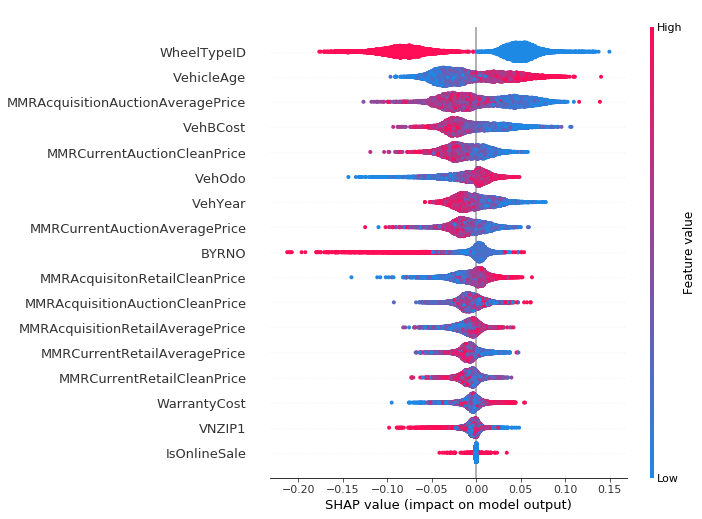

In [22]:
import shap

explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(val_X)

shap.summary_plot(shap_values[1], val_X)